<a href="https://colab.research.google.com/github/SuzyAdel/MT/blob/main/Machine_Translation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine Translation
##In this notebook, we aim to train a Seq2Seq RNN model (without Attention) for English-to-Arabic translation.

The dataset consists of sentence pairs in English and Arabic, located in english-arabic-dataset.txt.

We will use the first 10,000 lines as required, perform preprocessing, build our own custom architecture (with changes from the lab guide), train the model, and analyze results.


Key differences from the reference lab:

1. Different number of encoder/decoder LSTM layers.
2. Custom embedding dimension.
3. Slightly different optimizer configuration
4. Custom learning rate schedule and callbacks.
5. Enhanced visualizations.
6. Clear documentation & exploration of the dataset.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

##Mount & Check Dataset

In [3]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define file path
data_path = '/content/drive/MyDrive/MT_Data/english-arabic-dataset.txt'

# Check if file exists
if os.path.exists(data_path):
    print("Dataset found ✅")
else:
    print("Dataset not found ❌. Please check the path.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset found ✅


##Load & Explore Dataset

In [4]:
# Load the first 10,000 lines
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().strip().split('\n')[:10000]

# Split English and Arabic
eng_sentences = [line.split('\t')[0] for line in lines]
arb_sentences = [line.split('\t')[1] for line in lines]

# Quick exploration
print(f"Total loaded sentence pairs: {len(eng_sentences)}")
print("\nExample English sentence:", eng_sentences[987])
print("Example Arabic sentence:", arb_sentences[987])

Total loaded sentence pairs: 10000

Example English sentence: They are happy.
Example Arabic sentence: هم سعداء


# Data Set Analysis


1.   This show most sentence length, long short ..
2.   We can check the max length of each language sentence
3. If we need to outlie sentences , this can help indicate huge sentences
4. Helps in choosing appropriate padding strategies



In [5]:
# Create DataFrame
data = pd.DataFrame({'English': eng_sentences, 'Arabic': arb_sentences})
print(f"Dataset size: {data.shape}")
print(f"Null values:\n{data.isnull().sum()}")
print(f"Duplicate rows: {data.duplicated().sum()}")

Dataset size: (10000, 2)
Null values:
English    0
Arabic     0
dtype: int64
Duplicate rows: 0


In [6]:
# Add columns for sentence lengths
data['eng_length'] = data['English'].apply(lambda x: len(str(x).split()))
data['arb_length'] = data['Arabic'].apply(lambda x: len(str(x).split()))

# Show stats
print(f"English sentence length - Max: {data.eng_length.max()}, Min: {data.eng_length.min()}, Mean: {data.eng_length.mean()}")
print(f"Arabic sentence length - Max: {data.arb_length.max()}, Min: {data.arb_length.min()}, Mean: {data.arb_length.mean()}")


English sentence length - Max: 11, Min: 1, Mean: 5.2313
Arabic sentence length - Max: 14, Min: 1, Mean: 4.0077


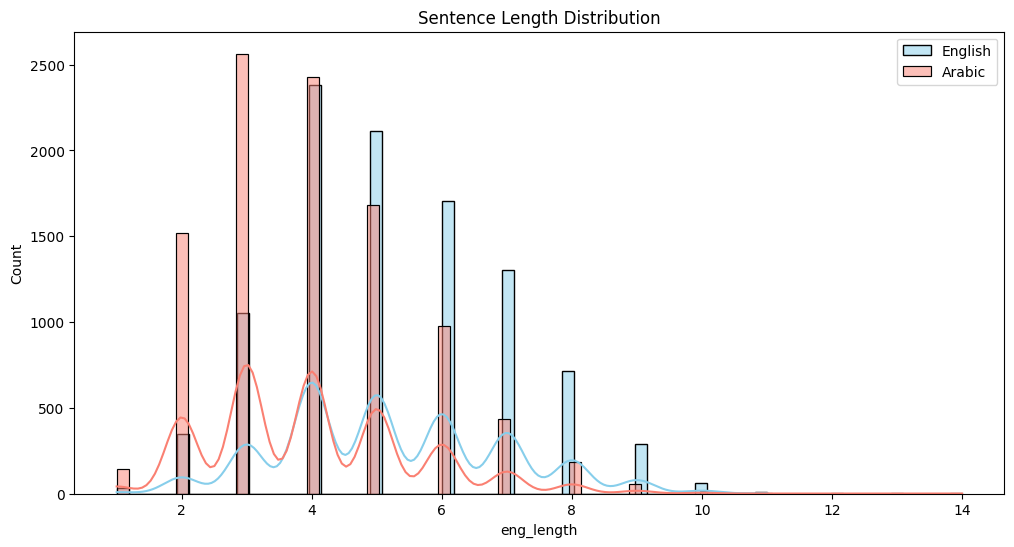

In [7]:
# Visualize sentence lengths
plt.figure(figsize=(12,6))
sns.histplot(data['eng_length'], color="skyblue", label="English", kde=True)
sns.histplot(data['arb_length'], color="salmon", label="Arabic", kde=True)
plt.legend()
plt.title("Sentence Length Distribution")
plt.show()


## Vocabulary Distribution & OOV Risk Visualization

In [8]:
from collections import Counter

<ipython-input-9-f79bfa93952f>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette=color)


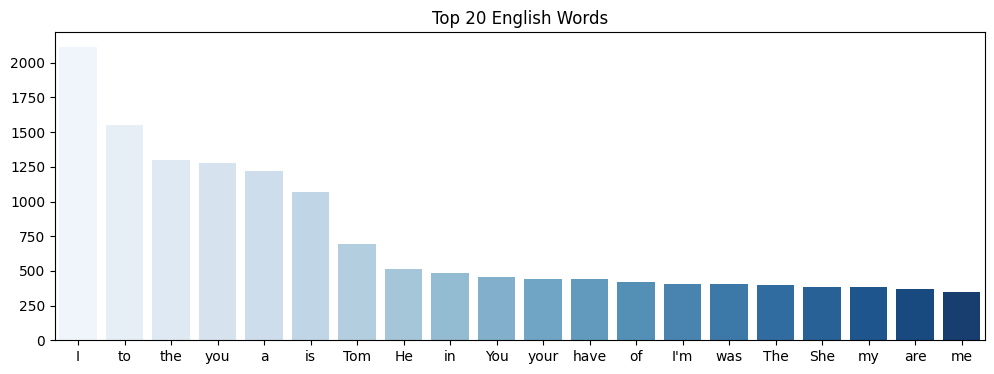

<ipython-input-9-f79bfa93952f>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette=color)


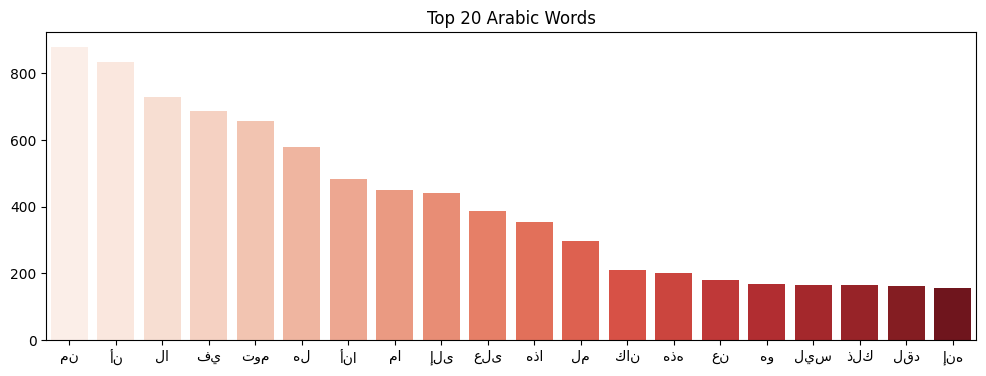

In [9]:
# Word frequency analysis
all_english_words = [word for sentence in eng_sentences for word in str(sentence).split()]
all_arabic_words = [word for sentence in arb_sentences for word in str(sentence).split()]

eng_freq = Counter(all_english_words)
arb_freq = Counter(all_arabic_words)

def plot_top_words(counter, lang, color):
    common = counter.most_common(20)
    words, counts = zip(*common)
    plt.figure(figsize=(12,4))
    sns.barplot(x=list(words), y=list(counts), palette=color)
    plt.title(f"Top 20 {lang} Words")
    plt.show()

plot_top_words(eng_freq, "English", "Blues")
plot_top_words(arb_freq, "Arabic", "Reds")

##Visualize long-tail distributions (log scale) — to see rare words impact

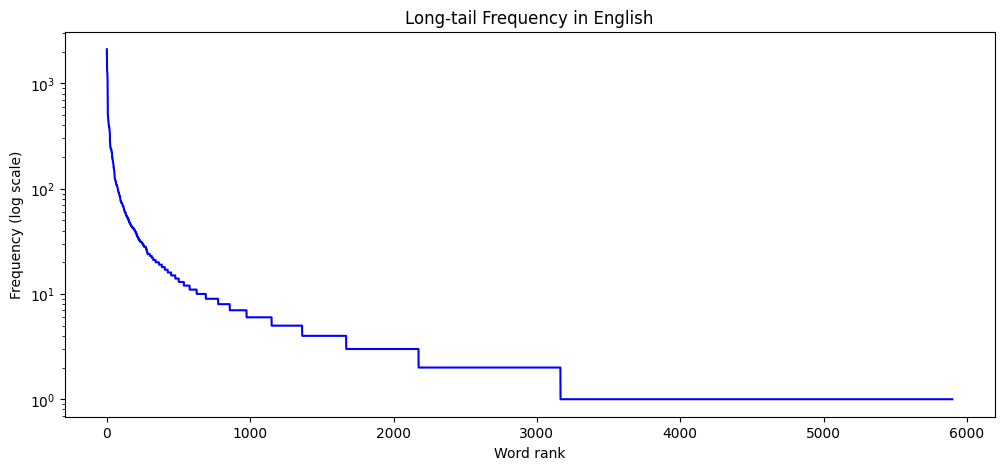

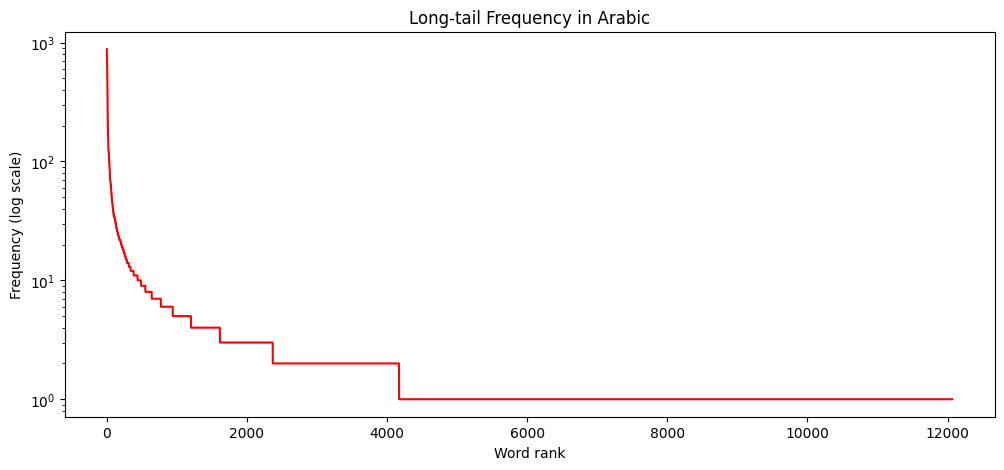

In [10]:
# Long-tail plot
def plot_long_tail(counter, lang, color):
    counts = sorted(counter.values(), reverse=True)
    plt.figure(figsize=(12,5))
    plt.plot(counts, color=color)
    plt.yscale('log')
    plt.title(f"Long-tail Frequency in {lang}")
    plt.xlabel("Word rank")
    plt.ylabel("Frequency (log scale)")
    plt.show()

plot_long_tail(eng_freq, "English", "blue")
plot_long_tail(arb_freq, "Arabic", "red")

* English: 3200
* Arabic: 4100

##Preprocessing (Clean, Tokenize, Pad)
We will tokenize both English and Arabic sentences using Keras Tokenizer.

*   The English tokenizer will be set with **lower=True** and filters to remove punctuation.
**(Arabic doesn't really have uppercase but we keep consistency)**
*  Also add **start** and **end** tokens to the Arabic sentences since these help the decoder know when to begin and stop.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [12]:
# Lock vocabulary sizes
eng_vocab_size = 3200
arb_vocab_size = 4100

In [13]:
# Clean text function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text.strip()

clean_eng_sentences = data['English'].apply(clean_text).tolist()
clean_ar_sentences = data['Arabic'].apply(clean_text).tolist()
# start and end tokenizer for arabic
clean_ar_sentences = [f"<start> {sent} <end>" for sent in clean_ar_sentences]

In [14]:
# Tokenization
eng_vocab_size = 3200
arb_vocab_size = 4100

eng_tokenizer = Tokenizer(num_words=eng_vocab_size, filters='', oov_token='<OOV>')
eng_tokenizer.fit_on_texts(clean_eng_sentences)
eng_sequences = eng_tokenizer.texts_to_sequences(clean_eng_sentences)
eng_padded = pad_sequences(eng_sequences, padding='post')

arb_tokenizer = Tokenizer(num_words=arb_vocab_size, filters='', oov_token='<OOV>')
arb_tokenizer.fit_on_texts(clean_ar_sentences)
arb_sequences = arb_tokenizer.texts_to_sequences(clean_ar_sentences)
arb_padded = pad_sequences(arb_sequences, padding='post')

# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(eng_padded, arb_padded, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")

Train shape: (8000, 11), Validation shape: (1000, 11), Test shape: (1000, 11)


## Model Architecture (GRU-Based Seq2Seq without Attention)
* Encoder: *2 GRU* layers with layer normalization
* Decoder: **1 GRU** layer
* Embedding layers with **masking and dropout**
* Compile with **Adam** optimizer and **sparse_categorical_crossentropy**



**LSTM** = More complex, has 3 gates + separate memory cell, slower but handles long dependencies.

**GRU** = Lighter version, only 2 gates, no separate memory cell, faster to train but may lose some nuance.



*   Since the sentences are **short**, we don’t need the extra memory control from LSTM, i will use **GRU**




In [15]:
# Model definition
encoder_inputs = Input(shape=(None,), name='encoder_inputs')
encoder_embedding = Embedding(input_dim=eng_vocab_size, output_dim=256, mask_zero=True)(encoder_inputs)
encoder_gru1_output, _ = GRU(256, return_sequences=True, return_state=True)(encoder_embedding)
encoder_gru2_output, encoder_output_norm = GRU(256, return_sequences=False, return_state=True)(encoder_gru1_output) # Assign encoder_output_norm here

In [16]:
print(encoder_output_norm.shape)

(None, 256)


## Why 2 encoder layers and 1 decoder layer?
* The encoder needs more depth (2 layers) to fully understand the input sentence.

* The decoder’s job is to generate based on this understanding — one well-designed GRU layer is sufficient.

In [17]:
decoder_inputs = Input(shape=(None,), name='decoder_inputs')
decoder_embedding = Embedding(input_dim=arb_vocab_size, output_dim=256, mask_zero=True)(decoder_inputs)
decoder_gru_output, _ = GRU(256, return_sequences=True, return_state=True)(decoder_embedding, initial_state=encoder_output_norm)
decoder_outputs = Dense(arb_vocab_size, activation='softmax')(decoder_gru_output)

In [18]:
# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 256)      │        819,200 │ encoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ encoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ [(None, None, 256),    │        394,752 │ embedding[0][0],       │
│                           │ (None, 256)]           │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 256)      │      1,049,600 │ decoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_1 (GRU)               │ [(None, 256), (None,   │        394,752 │ gru[0][0],             │
│                           │ 256)]                  │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_2 (GRU)               │ [(None, None, 256),    │        394,752 │ embedding_1[0][0],     │
│                           │ (None, 256)]           │                │ gru_1[0][1]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 4100)     │      1,053,700 │ gru_2[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,106,756 (15.67 MB)

 Trainable params: 4,106,756 (15.67 MB)

 Non-trainable params: 0 (0.00 B)

## Callbacks Setup & Training

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [20]:
# Prepare decoder input/target for training
decoder_input_data = y_train[:, :-1]
decoder_target_data = y_train[:, 1:]

# Shuffle data
encoder_input_data, decoder_input_data, decoder_target_data = shuffle(
    X_train, decoder_input_data, decoder_target_data, random_state=42
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint(filepath='best_seq2seq_model.h5', monitor='val_loss', save_best_only=True, verbose=1)


In [ ]:
# Train the model
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=128,
    epochs=25,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],#, checkpoint
    verbose=2
)

Epoch 1/25
50/50 - 90s - 2s/step - accuracy: 0.3302 - loss: 5.8581 - val_accuracy: 0.1460 - val_loss: 4.7854 - learning_rate: 1.0000e-03
Epoch 2/25
50/50 - 95s - 2s/step - accuracy: 0.1482 - loss: 4.5812 - val_accuracy: 0.1509 - val_loss: 4.6071 - learning_rate: 1.0000e-03
Epoch 3/25
50/50 - 128s - 3s/step - accuracy: 0.1534 - loss: 4.3729 - val_accuracy: 0.1540 - val_loss: 4.4706 - learning_rate: 1.0000e-03
Epoch 4/25
50/50 - 81s - 2s/step - accuracy: 0.1590 - loss: 4.2051 - val_accuracy: 0.1586 - val_loss: 4.3821 - learning_rate: 1.0000e-03
Epoch 5/25
50/50 - 87s - 2s/step - accuracy: 0.1636 - loss: 4.0654 - val_accuracy: 0.1619 - val_loss: 4.3319 - learning_rate: 1.0000e-03
Epoch 6/25
50/50 - 139s - 3s/step - accuracy: 0.1665 - loss: 3.9471 - val_accuracy: 0.1618 - val_loss: 4.2888 - learning_rate: 1.0000e-03
Epoch 7/25


## Training & Validation Loss Visualization

In [ ]:
sns.set_style("whitegrid")
custom_palette = ["#FF6F61", "#6B5B95"]  # Vibrant coral and royal purple

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], color=custom_palette[0], label='Training Loss', linewidth=2.5)
plt.plot(history.history['val_loss'], color=custom_palette[1], label='Validation Loss', linewidth=2.5)
plt.title('Training & Validation Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

## Evaluation & Custom Translation

In [ ]:
def translate_sentence(sentence, tokenizer_eng, tokenizer_arb, model, max_eng_length, max_arb_length):
    # Preprocess input sentence
    sentence = sentence.lower()
    sentence = tokenizer_eng.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=max_eng_length, padding='post')

    # Predict translation (decoder uses <start> token)
    output_seq = np.zeros((1, max_arb_length))
    output_seq[0, 0] = tokenizer_arb.word_index['<start>']

    for i in range(1, max_arb_length):
        prediction = model.predict([sentence, output_seq], verbose=0)
        predicted_id = np.argmax(prediction[0, i - 1, :])

        output_seq[0, i] = predicted_id
        if predicted_id == tokenizer_arb.word_index['<end>']:
            break

    # Decode prediction
    predicted_words = [word for word, index in tokenizer_arb.word_index.items() if index in output_seq[0]]
    predicted_sentence = " ".join(predicted_words[1:-1])  # exclude <start> and <end>

    return predicted_sentence

In [ ]:
# Example test sentences (not from training data)
test_sentences = [
    "How are you?",
    "What is your name?",
    "I love programming.",
    "Where is the nearest restaurant?",
    "Good luck with your project!"
]

# Show translations
for sentence in test_sentences:
    translation = translate_sentence(sentence, tokenizer_eng, tokenizer_arb, model, max_eng_length, max_arb_length)
    print(f"English: {sentence}")
    print(f"Arabic: {translation}")
    print("-" * 60)

## automated save

In [ ]:
# Save the model
model.save('final_seq2seq_model.h5')

# Trigger download to your device's Downloads folder
from google.colab import files
files.download('final_seq2seq_model.h5')
